In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
maxdt = pd.read_sql("SELECT distinct max(date) FROM measurement", conn)
enddt = pd.to_datetime(maxdt['max(date)']).tolist()
enddt = enddt[0]
begdt = enddt - dt.timedelta(365)
# Perform a query to retrieve the data and precipitation scores
query = "Select date, prcp as 'precipitation' from measurement where date between '" + begdt.strftime("%Y-%m-%d") + "' and '" + enddt.strftime("%Y-%m-%d") + "' order by date asc;"

# Save the query results as a Pandas DataFrame and set the index to the date column
data = pd.read_sql(query,conn)
data = data.set_index('date')
# Sort the dataframe by date
# already done in query


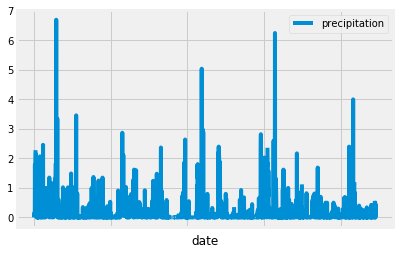

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
data.plot()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
st = pd.read_sql("select count(1) from (select distinct id from station) s;",conn)
count_station = st['count(1)'][0]
count_station

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# The most active station (with the most rows) is:
top1station = pd.read_sql("select s.id as 'station_id', s.station, s.name, s.latitude, s.longitude, s.elevation, count(1) as 'num_rows' from measurement m inner join station s on m.station = s.station group by s.id order by num_rows desc limit 1;",conn)
i = str(top1station["station_id"][0])
top1station
# List the stations and the counts in descending order.
topstations = pd.read_sql("select s.id as 'station_id', s.station, s.name, s.latitude, s.longitude, s.elevation, count(1) as 'num_rows' from measurement m inner join station s on m.station = s.station group by s.id order by num_rows desc;",conn)
topstations

,station_id,station,name,latitude,longitude,elevation,num_rows
0,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2772
1,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2724
2,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2709
3,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2669
4,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2612
5,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2202
6,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,1979
7,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,1372
8,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,511


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
#Most active station (top 1) from previous query is:
query_temp = "select s.id, m.station, s.name, max(m.tobs) 'highest', avg(m.tobs) as 'average', min(m.tobs) as 'lowest' from measurement m inner join station s on m.station = s.station where s.id = " + i + " group by s.id;"
top1station_temp = pd.read_sql(query_temp,conn)
top1station_temp

,id,station,name,highest,average,lowest
0,7,USC00519281,"WAIHEE 837.5, HI US",85.0,71.663781,54.0


(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 53., 29.,  8.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <a list of 12 Patch objects>)

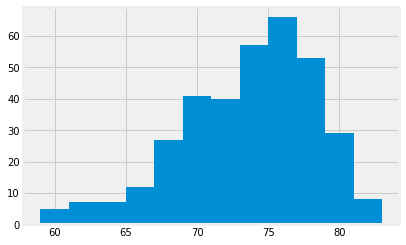

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_freq = "select m.date, m.tobs from measurement m inner join station s on m.station = s.station where s.id = " + i + " and date between '" + begdt.strftime("%Y-%m-%d") + "' and '" + enddt.strftime("%Y-%m-%d") + "';"
top1station_freq = pd.read_sql(query_freq,conn)
tobs = top1station_freq['tobs']
plt.hist(tobs,bins = 12)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
c = calc_temps('2017-01-01', '2018-01-01')
print(c)

[(58.0, 74.14387974230493, 87.0)]


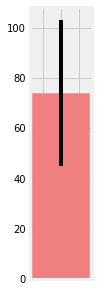

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(1,5))
x = 0
y = c[0][1]
bar = plt.bar(x,y, xerr = 0, yerr = (c[0][2]-c[0][0]))
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
bar[0].set_color('lightcoral')

In [20]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = pd.read_sql("select s.*, sum(m.prcp) as 'rainfall' from measurement m inner join station s on m.station = s.station where date between '2017-01-01' and '2018-01-01' group by s.id order by rainfall desc;",conn)
rainfall

,id,station,name,latitude,longitude,elevation,rainfall
0,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,68.78
1,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,43.66
2,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,34.62
3,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,27.32
4,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,21.80
5,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,10.66
6,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,3.39


## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
